In [1]:
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import lsst.meas.base
import lsst.pex.config
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import lsst.afw.table
import lsst.meas.algorithms
import lsst.meas.deblender
import lsst.pex.exceptions
import lsst.meas.extensions.gaap
import cProfile, pstats

## Try gaap with reference catalog

In [2]:
# Load Merian catalog
filt = 'N708'
tract = 9813
patch = 79

import lsst.daf.butler as dafButler
butler = dafButler.Butler('/projects/MERIAN/repo/')
dataId = dict(tract=tract, patch=patch, band=filt)
refCat = butler.get(
    'deepCoadd_forced_src',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)

refExposure = butler.get(
    'deepCoadd_calexp',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)

In [10]:
exposure = lsst.afw.image.ExposureF(
    "/projects/MERIAN/repo/DECam/runs/merian/dr1_wide/20220921T193246Z/deepCoadd_calexp/9813/79/N708/deepCoadd_calexp_9813_79_N708_hsc_rings_v1_DECam_runs_merian_dr1_wide_20220921T193246Z.fits")

In [11]:
# exposure = lsst.afw.image.ExposureF("/projects/MERIAN/repo/S20A/9813/8,7.fits")

In [12]:
# # this thing has footprint
# fpCat = lsst.afw.table.SourceTable.Catalog.readFits(
#     '/projects/MERIAN/repo/S20A/9813/8,7/deblendedFlux-HSC-I-9813-8,7.fits')

In [15]:
measureTask = lsst.meas.base.ForcedPhotCoaddTask(refSchema=refCat.schema)

filt = 'N708'
tract = 9813
patch = 79
dataId = dict(tract=tract, patch=patch, band=filt, skymap='hsc_rings_v1', instrument='DECam')
dataId = butler.registry.expandDataId(dataId)

catalog, expid = measureTask.generateMeasCat(dataId, exposure, refCat, refCat, refExposure.wcs, 'tract_patch', refCat)

AttributeError: 'lsst.afw.table._table.SourceColumnView' object has no attribute 'updateCatalogFootprints'

In [8]:
measureTask.runDataRef(butler)

KeyError: "Dataset type with name 'deepCoadd_skyMap' not found."

In [ ]:
doReplaceWithNoise

In [ ]:
measureTask.config.measurement.plugins

In [80]:
measureTask.config.measurement.plugins['ext_gaap_GaapFlux'].values()

[True,
 [0.7, 1.0],
 [1.15],
 65,
 False,
 True,
 True]

In [66]:
fpCat

<class 'lsst.afw.table.SourceCatalog'>
        id        coord_ra coord_dec       parent      ... deblend_skipped deblend_rampedTemplate deblend_patchedTemplate deblend_hasStrayFlux
                    rad       rad                      ...                                                                                    
----------------- -------- --------- ----------------- ... --------------- ---------------------- ----------------------- --------------------
43159159989862401      nan       nan                 0 ...           False                  False                   False                False
43159159989862403      nan       nan                 0 ...           False                  False                   False                False
43159159989862404      nan       nan                 0 ...           False                  False                   False                False
43159159989862405      nan       nan                 0 ...           False                  False      

In [65]:
a.getId()

3496147909164924929

In [63]:
for refRecord, srcRecord in zip(refCat, catalog):
    fpRecord = fpCat.find(refRecord.getId())
    if fpRecord is None:
        raise LookupError("Cannot find Footprint for source %s; please check that %sCoadd_%s "
                          "IDs are compatible with reference source IDs" %
                          (srcRecord.getId(), measureTask.config.coaddName,
                           measureTask.config.footprintDatasetName))
    srcRecord.setFootprint(fpRecord.getFootprint())

LookupError: Cannot find Footprint for source 3496147909164924929; please check that deepCoadd_meas IDs are compatible with reference source IDs

In [56]:
catalog

<class 'lsst.afw.table.SourceCatalog'>
         id              coord_ra           coord_dec       ... base_PsfFlux_apCorr base_PsfFlux_apCorrErr base_PsfFlux_flag_apCorr
                           rad                 rad          ...                                                                    
------------------- ------------------ -------------------- ... ------------------- ---------------------- ------------------------
3496147909164924929 2.6140370209365806  0.05027185619760324 ...                 nan                    nan                    False
3496147909164924930  2.613832353611896  0.05027177005269444 ...                 nan                    nan                    False
3496147909164924931 2.6136219791749125 0.050271679314625596 ...                 nan                    nan                    False
3496147909164924932 2.6135844673061523  0.05028143511922102 ...                 nan                    nan                    False
3496147909164924933  2.61352657706661

In [44]:
# measureTask.attachFootprints(catalog, refCat, exposure, refExposure.wcs, None)

In [45]:
print("# Starting the measureTask at ", time.ctime())
t1 = time.time()
output = measureTask.run(catalog, exposure, refCat, refExposure.wcs, exposureId=expid)
t2 = time.time()
print("# Finished measureTask in %.2f seconds." % (t2-t1))

# Starting the measureTask at  Tue Nov  1 19:11:31 2022


FatalAlgorithmError: 
  File "src/InputUtilities.cc", line 90, in lsst::geom::Point2D lsst::meas::base::SafeCentroidExtractor::operator()(lsst::afw::table::SourceRecord&, const lsst::meas::base::FlagHandler&) const
    base_SdssShape requires a centroid, but the centroid slot is not defined {0}
lsst::meas::base::FatalAlgorithmError: 'base_SdssShape requires a centroid, but the centroid slot is not defined'


In [55]:
output

Struct(measCat=         id              coord_ra           coord_dec       ... base_PsfFlux_apCorr base_PsfFlux_apCorrErr base_PsfFlux_flag_apCorr
                           rad                 rad          ...                                                                    
------------------- ------------------ -------------------- ... ------------------- ---------------------- ------------------------
3496147909164924929 2.6140370209365806  0.05027185619760324 ...  0.9885354876437352                    0.0                    False
3496147909164924930  2.613832353611896  0.05027177005269444 ...  0.9887008885429822                    0.0                    False
3496147909164924931 2.6136219791749125 0.050271679314625596 ...  0.9900752473581665                    0.0                    False
3496147909164924932 2.6135844673061523  0.05028143511922102 ...  0.9900897409047343                    0.0                    False
3496147909164924933  2.613526577066613  0.05027163743405386 .

In [ ]:
output

In [7]:
schema = lsst.afw.table.SourceTable.makeMinimalSchema()
detectConfig = lsst.meas.algorithms.SourceDetectionConfig()
detectConfig.returnOriginalFootprints = False
detectConfig.thresholdValue = 10
detectTask = lsst.meas.algorithms.SourceDetectionTask(config=detectConfig, schema=schema)
deblendTask = lsst.meas.deblender.SourceDeblendTask(schema=schema)

measureTask2 = lsst.meas.base.ForcedMeasurementTask(refSchema=refCat.schema)
measureTask2.config.plugins.names.add("base_SdssShape")
measureTask2.config.plugins.names.add("base_SdssCentroid")
measureTask2.config.plugins.names.add("ext_gaap_GaapFlux")
measureTask2.config.plugins["ext_gaap_GaapFlux"].doMeasure = True  # Set it to False for timing comparison
measureTask2.config.plugins["ext_gaap_GaapFlux"].doPsfPhotometry = True
measureTask2.config.plugins["ext_gaap_GaapFlux"].doOptimalPhotometry = False
measureTask2.config.plugins["ext_gaap_GaapFlux"].sigmas = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

In [6]:
# exposure = lsst.afw.image.ExposureF("/projects/MERIAN/repo/S20A/9813/8,7.fits")
exposure = lsst.afw.image.ExposureF("/projects/MERIAN/repo/DECam/runs/merian/dr1_wide/20220921T193246Z/deepCoadd_calexp/9813/79/N708/deepCoadd_calexp_9813_79_N708_hsc_rings_v1_DECam_runs_merian_dr1_wide_20220921T193246Z.fits")
# table = lsst.afw.table.SourceTable.make(schema)
# detectResult = detectTask.run(table, exposure)
# catalog = detectResult.sources
# catalog = measureTask.generateMeasCat(refExposure, refCat, refExposure.wcs)

In [8]:
catalog = measureTask2.generateMeasCat(refExposure, refCat, refExposure.wcs)

In [10]:
catalog.asAstropy()

id,coord_ra,coord_dec,parent,objectId,parentObjectId,deblend_nChild,base_SdssCentroid_x,base_SdssCentroid_y,base_SdssCentroid_xErr,base_SdssCentroid_yErr,base_SdssCentroid_flag,base_SdssCentroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_TransformedCentroid_x,slot_Centroid_x,base_TransformedCentroid_y,slot_Centroid_y,base_TransformedCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_PsfFlux_flag_badCentroid,base_SdssCentroid_flag_badInitialCentroid,base_SdssShape_flag_badCentroid,slot_Centroid_flag,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,base_SdssShape_xxErr,base_SdssShape_yyErr,base_SdssShape_xyErr,base_SdssShape_x,base_SdssShape_y,base_SdssShape_instFlux,base_SdssShape_instFluxErr,base_SdssShape_psf_xx,slot_PsfShape_xx,base_SdssShape_psf_yy,slot_PsfShape_yy,base_SdssShape_psf_xy,slot_PsfShape_xy,base_SdssShape_instFlux_xx_Cov,base_SdssShape_instFlux_yy_Cov,base_SdssShape_instFlux_xy_Cov,base_SdssShape_flag,base_SdssShape_flag_unweightedBad,base_SdssShape_flag_unweighted,base_SdssShape_flag_shift,base_SdssShape_flag_maxIter,base_SdssShape_flag_psf,base_TransformedShape_xx,slot_Shape_xx,base_TransformedShape_yy,slot_Shape_yy,base_TransformedShape_xy,slot_Shape_xy,base_TransformedShape_flag,base_GaussianFlux_flag_badShape,slot_Shape_flag,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,base_CircularApertureFlux_3_0_flag,base_CircularApertureFlux_3_0_flag_apertureTruncated,base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_4_5_instFlux,base_CircularApertureFlux_4_5_instFluxErr,base_CircularApertureFlux_4_5_flag,base_CircularApertureFlux_4_5_flag_apertureTruncated,base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,base_CircularApertureFlux_6_0_instFlux,base_CircularApertureFlux_6_0_instFluxErr,base_CircularApertureFlux_6_0_flag,base_CircularApertureFlux_6_0_flag_apertureTruncated,base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_9_0_instFlux,base_CircularApertureFlux_9_0_instFluxErr,base_CircularApertureFlux_9_0_flag,base_CircularApertureFlux_9_0_flag_apertureTruncated,base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_12_0_instFlux,base_CircularApertureFlux_12_0_instFluxErr,base_CircularApertureFlux_12_0_flag,base_CircularApertureFlux_12_0_flag_apertureTruncated,base_CircularApertureFlux_17_0_instFlux,base_CircularApertureFlux_17_0_instFluxErr,base_CircularApertureFlux_17_0_flag,base_CircularApertureFlux_17_0_flag_apertureTruncated,base_CircularApertureFlux_25_0_instFlux,base_CircularApertureFlux_25_0_instFluxErr,base_CircularApertureFlux_25_0_flag,base_CircularApertureFlux_25_0_flag_apertureTruncated,base_CircularApertureFlux_35_0_instFlux,base_CircularApertureFlux_35_0_instFluxErr,base_CircularApertureFlux_35_0_flag,base_CircularApertureFlux_35_0_flag_apertureTruncated,base_CircularApertureFlux_50_0_instFlux,base_CircularApertureFlux_50_0_instFluxErr,base_CircularApertureFlux_50_0_flag,base_CircularApertureFlux_50_0_flag_apertureTruncated,base_CircularApertureFlux_70_0_instFlux,base_CircularApertureFlux_70_0_instFluxErr,base_CircularApertureFlux_70_0_flag,base_CircularApertureFlux_70_0_flag_apertureTruncated,base_GaussianFlux_instFlux,base_GaussianFlux_instFluxErr,base_GaussianFlux_flag,base_LocalBackground_instFlux,base_LocalBackground_instFluxErr,base_LocalBackground_flag,base_LocalBackground_flag_noGoodPixels,base_LocalBackground_flag_noPsf,base_PixelFlags_flag,base_PixelFlags_flag_offimage,base_PixelFlags_flag_edge,base_PixelFlags_flag_interpolated,base_PixelFlags_flag_saturated,base_PixelFlags_flag_cr,base_PixelFlags_flag_bad,base_PixelFlags_flag_suspect,base_PixelFlags_flag_interpolatedCenter,base_PixelFlags_flag_saturatedCenter,base_Pixe

In [91]:
print("# About to start the deblendTask at ", time.ctime())
t1 = time.time()
deblendTask.run(exposure, catalog)
t2 = time.time()
print("# Finished deblendTask in %.2f seconds." % (t2-t1))

# About to start the deblendTask at  Tue Nov  1 14:56:31 2022
# Finished deblendTask in 55.19 seconds.


In [75]:
# catalog2 = measureTask2.generateMeasCat(refExposure, refCat, refExposure.wcs)

In [93]:
print("# Starting the measureTask at ", time.ctime())
t1 = time.time()
measureTask2.run(catalog, exposure, refCat=refCat, refWcs=refExposure.wcs)
t2 = time.time()
print("# Finished measureTask in %.2f seconds." % (t2-t1))

# Starting the measureTask at  Tue Nov  1 14:57:43 2022
# Finished measureTask in 96.24 seconds.


In [96]:
cat2 = catalog.copy(deep=True).asAstropy()

[]

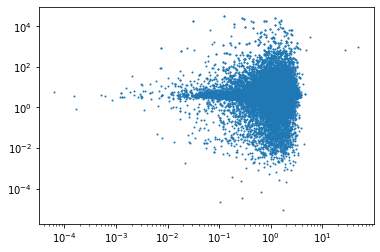

In [76]:
plt.scatter(output.measCat['base_PsfFlux_instFlux'], refCat['base_PsfFlux_instFlux'], s=1)

plt.loglog()

In [68]:
output.measCat.schema.getNames()

{'base_CircularApertureFlux_12_0_flag',
 'base_CircularApertureFlux_12_0_flag_apertureTruncated',
 'base_CircularApertureFlux_12_0_instFlux',
 'base_CircularApertureFlux_12_0_instFluxErr',
 'base_CircularApertureFlux_17_0_flag',
 'base_CircularApertureFlux_17_0_flag_apertureTruncated',
 'base_CircularApertureFlux_17_0_instFlux',
 'base_CircularApertureFlux_17_0_instFluxErr',
 'base_CircularApertureFlux_25_0_flag',
 'base_CircularApertureFlux_25_0_flag_apertureTruncated',
 'base_CircularApertureFlux_25_0_instFlux',
 'base_CircularApertureFlux_25_0_instFluxErr',
 'base_CircularApertureFlux_35_0_flag',
 'base_CircularApertureFlux_35_0_flag_apertureTruncated',
 'base_CircularApertureFlux_35_0_instFlux',
 'base_CircularApertureFlux_35_0_instFluxErr',
 'base_CircularApertureFlux_3_0_flag',
 'base_CircularApertureFlux_3_0_flag_apertureTruncated',
 'base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated',
 'base_CircularApertureFlux_3_0_instFlux',
 'base_CircularApertureFlux_3_0_instFluxErr',


In [65]:
output.measCat['undeblended_ext_gaap_GaapFlux_1_15x_2_5_instFlux']

KeyError: "Field with name 'undeblended_ext_gaap_GaapFlux_1_15x_2_5_instFlux' not found"

In [62]:
np.sum(refCat['ext'] - output.measCat['coord_ra'])

0.0

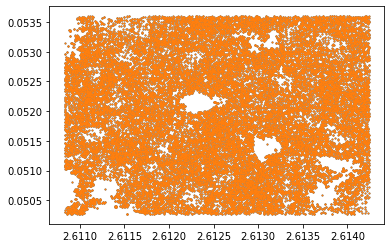

In [60]:
plt.scatter(output.measCat['coord_ra'], output.measCat['coord_dec'], s=1)
plt.scatter(refCat['coord_ra'], refCat['coord_dec'], s=1)

/tmp/ipykernel_55430/2063134128.py:1: RuntimeWarning: invalid value encountered in power
  plt.hist(0.168 * ((output.measCat['base_SdssShape_xx'] * output.measCat['base_SdssShape_yy'] - output.measCat['base_SdssShape_xy']**2))**0.25,
/tmp/ipykernel_55430/2063134128.py:4: RuntimeWarning: invalid value encountered in power
  plt.hist(0.168 * ((refCat['base_SdssShape_xx'] * refCat['base_SdssShape_yy'] - refCat['base_SdssShape_xy']**2))**0.25,


(array([1.93389871, 0.56273282, 1.7163351 , 1.86137751, 1.9596576 ,
        0.87382104, 0.40461282, 0.20408972, 0.1109614 , 0.07093604,
        0.04517714, 0.04517714, 0.04398827, 0.02734406, 0.02417373,
        0.02774035, 0.02813664, 0.02457002, 0.01981454, 0.01545534]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 [<matplotlib.patches.Polygon at 0x2b0440560220>])

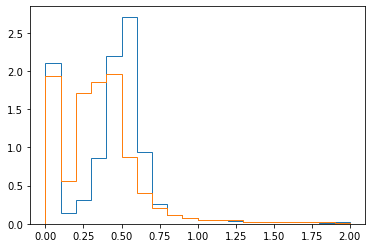

In [56]:
plt.hist(0.168 * ((output.measCat['base_SdssShape_xx'] * output.measCat['base_SdssShape_yy'] - output.measCat['base_SdssShape_xy']**2))**0.25,
         range=(0, 2), bins=20, histtype='step', density=True)

plt.hist(0.168 * ((refCat['base_SdssShape_xx'] * refCat['base_SdssShape_yy'] - refCat['base_SdssShape_xy']**2))**0.25,
         range=(0, 2), bins=20, histtype='step', density=True)

In [57]:
len(refCat)

31425

In [58]:
len(output.measCat)

31425

In [122]:
X, Y = [], []
for record in catalog[good_objects]:
    snr_list = []
    optShape = afwGeom.Quadrupole(record["ext_gaap_GaapFlux_OptimalShape_xx"],
                                  record["ext_gaap_GaapFlux_OptimalShape_yy"],
                                  record["ext_gaap_GaapFlux_OptimalShape_xy"],)
    optSigma = optShape.getDeterminantRadius()
    optSigma = numpy.round(optSigma*2,0)/2
    optName = measureConfig.plugins["ext_gaap_GaapFlux"]._getGaapResultName(1.15, optSigma, "ext_gaap_GaapFlux")
    for baseName in measureConfig.plugins["ext_gaap_GaapFlux"].getAllGaapResultNames("ext_gaap_GaapFlux"):
        if not ("PsfFlux" in baseName or "Optimal" in baseName):
            try:
                snr = record[baseName+"_instFlux"]/record[baseName+"_instFluxErr"]
                snr_list.append(snr)
            except ZeroDivisionError:
                continue
        elif "Optimal" in baseName:
            optimalSnr = record[baseName+"_instFlux"]/record[baseName+"_instFluxErr"]

        if baseName==optName:
            optSnr = snr
        if 'x_3_5' in baseName:
            optSnr = snr
            
    boostFactor = optimalSnr/optSnr # numpy.nanpercentile(snr_list, 50)
    shape = record.getShape()
    ellip = (shape.getIxx()-shape.getIyy()) + 1j*2*shape.getIxy()
    ellip /= (shape.getIxx()+shape.getIyy())
    
    X.append( numpy.hypot(ellip.real, ellip.imag))
    Y.append(boostFactor)
    
Y = numpy.array(Y)

Text(0.5, 1.0, 'Plot covers 14.38 % of the sources.')

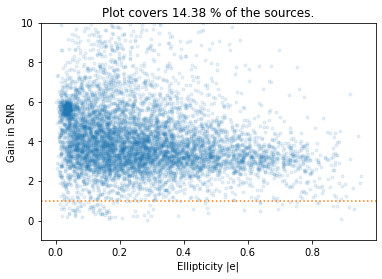

In [123]:
plt.plot(X, Y, '.', alpha=0.1)
plt.axhline(1.0, color='C1',ls=':')
#plt.yscale('log')
plt.ylabel("Gain in SNR")
plt.xlabel("Ellipticity |e|")
# ymin, ymax = 0.8, 2.7
plt.ylim([-1, 10])
plt.title(f"Plot covers {100.*((Y>ymin)&(Y<ymax)).mean():.2f} % of the sources.")

In [48]:
def printShape(shape):
    ixx, iyy, ixy = shape.getParameterVector()
    det = shape.getDeterminantRadius()
    complex_ellip = ((ixx-iyy)+1j*2*ixy)/(ixx+iyy)
    ellip = numpy.hypot(complex_ellip.real, complex_ellip.imag)
    # return f"Quad(ixx={ixx:.2f}, iyy={iyy:.2f}, ixy={ixy:.2f}); det={det:.1f}; |e|={ellip:.2f}"
    return rf"$\sigma = ${det:.1f}; |e|={ellip:.2f}"

printShape(shape)

'$\\sigma = $1.8; |e|=0.17'

Text(0.5, 1.0, 'recordId = 210')

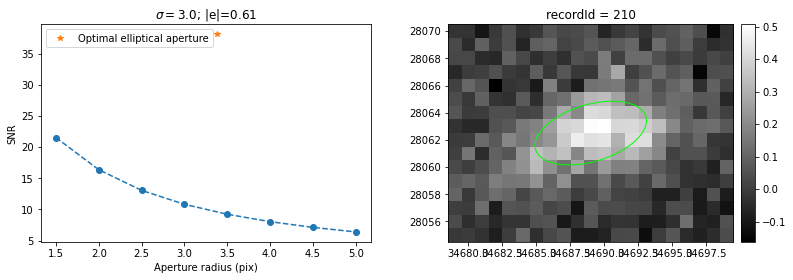

In [50]:
recordId = 210
scalingFactor = 1.15

def getSnr(sigmas):
    for sigma in sigmas:
        baseName = measureConfig.plugins["ext_gaap_GaapFlux"]._getGaapResultName(scalingFactor, sigma, "ext_gaap_GaapFlux")
        snr = catalog[recordId][baseName+"_instFlux"]/catalog[recordId][baseName+"_instFluxErr"]
        yield snr
        
sigmas = numpy.array(measureConfig.plugins["ext_gaap_GaapFlux"].sigmas)
snrs = numpy.array(list(getSnr(sigmas)))

fig, ax = plt.subplots(1, 2, figsize=(13,4))
ax[0].plot(sigmas[snrs>0], snrs[snrs>0], 'o--')

shape = catalog[recordId].getShape()
optShape = afwGeom.Quadrupole(catalog[recordId]["ext_gaap_GaapFlux_OptimalShape_xx"],
                              catalog[recordId]["ext_gaap_GaapFlux_OptimalShape_yy"],
                              catalog[recordId]["ext_gaap_GaapFlux_OptimalShape_xy"],)
sigma = optShape.getDeterminantRadius()
snr = list(getSnr(("Optimal",)))[0]
ax[0].plot(sigma, snr, '*', label='Optimal elliptical aperture')

ax[0].set_ylabel("SNR")
ax[0].set_xlabel("Aperture radius (pix)")
ax[0].set_title(printShape(shape))
#plt.yscale('log')
ax[0].legend(loc='best')


afwDisplay.setDefaultBackend('matplotlib')
plt.sca(ax[1])
display = afwDisplay.Display(frame=fig)
# display.scale("linear", "zscale")
display.setMaskTransparency(100)
footprint = catalog[recordId].getFootprint()
bbox = footprint.getBBox()
cutout = exposure[bbox]
display.mtv(cutout)
display.dot(shape, *bbox.getCenter())
ax[1].set_title(f"recordId = {recordId}")

In [16]:
import astropy.units as u
from astropy.table import Table

In [131]:
filt = 'N708'
tract = 9813
patch = 79

import lsst.daf.butler as dafButler
butler = dafButler.Butler('/projects/MERIAN/repo/')
dataId = dict(tract=tract, patch=patch, band=filt)
refCat = butler.get(
    'deepCoadd_forced_src',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)
img = butler.get(
    'deepCoadd',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)

In [19]:
refCat

<class 'lsst.afw.table.SourceCatalog'>
         id              coord_ra      ... base_ClassificationExtendedness_flag
                           rad         ...                                     
------------------- ------------------ ... ------------------------------------
3496147909164924929 2.6140370209365806 ...                                 True
3496147909164924930  2.613832353611896 ...                                 True
3496147909164924931 2.6136219791749125 ...                                 True
3496147909164924932 2.6135844673061523 ...                                 True
3496147909164924933  2.613526577066613 ...                                 True
3496147909164924934 2.6134132363085603 ...                                 True
3496147909164924935 2.6131881848261638 ...                                 True
3496147909164924936 2.6131580165950434 ...                                 True
3496147909164924937 2.6127649905191834 ...                                 True
3

In [ ]:
filt = 'N708'
tract = 9813
patch = 79

import lsst.daf.butler as dafButler
butler = dafButler.Butler('/projects/MERIAN/repo/')
dataId = dict(tract=tract, patch=patch, band=filt)
refCat = butler.get(
    'deepCoadd_forced_src',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)
img = butler.get(
    'deepCoadd',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)

In [ ]:
from collections import defaultdict
import lsst.daf.butler as dafButler

butler = dafButler.Butler('/project/lskelvin/repo')

grouped_by_tract = defaultdict(set)
for data_id in butler.registry.queryDataIds(
    ["tract", "visit", "detector"],
    datasets="visitSummary",
    collections="DECam/runs/merian9813/w_2022_26",
    instrument="DECam",
    visit=971666,
):
    grouped_by_tract[data_id["tract"]].add(data_id)

print({k: len(v) for k, v in grouped_by_tract.items()})